In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
import os
import pathlib

df_train = pd.read_csv ('train_data.csv', sep=",")
df_val = pd.read_csv ('val_data.csv', sep=",")
df_test = pd.read_csv ('test_data.csv', sep=",")

classes = df_train["class"].value_counts()
print(classes)

1    2867
2     620
0     230
Name: class, dtype: int64


In [74]:
import re
def pre_process(df):
    def tweet_pre_process(tweet):
        ret = re.sub("RT @(.)+?:\s|(&#[0-9]+;)|@([\w\-]+)|(#)\S+|(http)s?\S+|&gt;|^\s+|\b\s+|\n", "", tweet)
        ret = re.sub("\s\s+|[^a-zA-Z\d\s:]" , " ", ret).rstrip().lower()
        return ret
    return df["tweet"].apply(tweet_pre_process)

In [75]:
df_train["tweet"] = pre_process(df_train)
df_val["tweet"] = pre_process(df_val)
df_test["tweet"] = pre_process(df_test)

In [76]:
df_train.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,10831,3,0,2,1,1,i hit raw while im listening to papoose
1,17237,3,0,3,0,1,yes mimi bitch yo dumb ass got played
2,22311,3,1,2,0,1,these people at jury selection are retarded
3,12929,6,0,5,1,1,lol shawty at sheets gave me her number haha i...
4,16419,3,0,3,0,1,these bitches aint shit amp pussy is my grea...


In [77]:
x_train, y_train = df_train["tweet"], df_train["class"]
x_val, y_val = df_val["tweet"], df_val["class"]
x_test, y_test = df_test["tweet"], df_test["class"]

In [78]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=400)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)

In [79]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [80]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [81]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 5888 words (738 misses)


In [82]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [83]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, padding='same', activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, padding='same', activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, padding='same', activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(classes), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 100)         662800    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 128)         8204

In [84]:
x_train_vec = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val_vec = vectorizer(np.array([[s] for s in x_val])).numpy()
x_test_vec = vectorizer(np.array([[s] for s in x_test])).numpy()

y_train_vec = np.array(y_train)
y_val_vec = np.array(y_val)
y_test_vec = np.array(y_test)

In [85]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics="accuracy")
hist = model.fit(x_train_vec, y_train_vec, epochs=10, validation_data=(x_val_vec, y_val_vec))

Epoch 1/10
117/117 [==============================] - 2s 12ms/step - loss: 0.7731 - accuracy: 0.7221 - val_loss: 0.6325 - val_accuracy: 0.7829
Epoch 2/10
117/117 [==============================] - 1s 10ms/step - loss: 0.6541 - accuracy: 0.7711 - val_loss: 0.5722 - val_accuracy: 0.7856
Epoch 3/10
117/117 [==============================] - 1s 10ms/step - loss: 0.5548 - accuracy: 0.7996 - val_loss: 0.4950 - val_accuracy: 0.8330
Epoch 4/10
117/117 [==============================] - 1s 10ms/step - loss: 0.4837 - accuracy: 0.8364 - val_loss: 0.4442 - val_accuracy: 0.8472
Epoch 5/10
117/117 [==============================] - 1s 10ms/step - loss: 0.4131 - accuracy: 0.8639 - val_loss: 0.4103 - val_accuracy: 0.8564
Epoch 6/10
117/117 [==============================] - 1s 10ms/step - loss: 0.3682 - accuracy: 0.8781 - val_loss: 0.3951 - val_accuracy: 0.8604
Epoch 7/10
117/117 [==============================] - 1s 10ms/step - loss: 0.3199 - accuracy: 0.8972 - val_loss: 0.3897 - val_accuracy: 0.8612

In [89]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


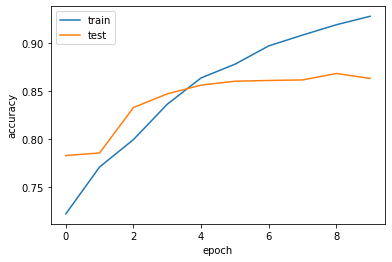

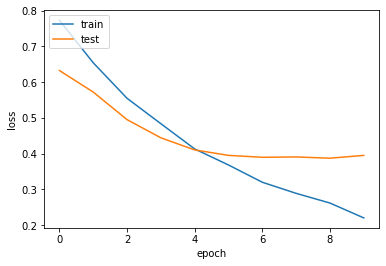

In [90]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['accuracy','val_accuracy'])
plot_history(hist,['loss','val_loss'])


In [91]:
from sklearn.metrics import classification_report

y_d = model.predict(x_test_vec)
y_d = np.argmax(y_d, axis=1)
y_t =y_test_vec
print(y_d[y_d==0].shape, y_d[y_d==1].shape, y_d[y_d==2].shape)
print(classification_report(y_t, y_d))

(21,) (14532,) (2795,)
              precision    recall  f1-score   support

           0       0.57      0.01      0.02       998
           1       0.89      0.96      0.92     13412
           2       0.75      0.72      0.74      2938

    accuracy                           0.86     17348
   macro avg       0.74      0.56      0.56     17348
weighted avg       0.85      0.86      0.84     17348

